## 1- Import dependances

In [1]:
!pip install -q efficientnet

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn import metrics
from keras import regularizers, optimizers
import tensorflow.keras.backend as K
import datetime, time, pickle
import efficientnet.tfkeras as efn
import pandas as pd
from sklearn.utils import class_weight
from collections import Counter

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Using TensorFlow backend.


Tensorflow version 2.1.0


In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
    
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## 2- Competition data access

In [4]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

Configuration

In [5]:
IMAGE_SIZE = [512,512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.
EPOCHS = 20
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

## 3- Callback scheduler

1e-05 2.0307921510400007e-05
[1e-05, 3.142857142857143e-05, 5.285714285714286e-05, 7.428571428571429e-05, 9.571428571428573e-05, 0.00011714285714285716, 0.00013857142857142857, 0.00016, 0.00013000000000000002, 0.00010600000000000003, 8.680000000000002e-05, 7.144000000000002e-05, 5.915200000000002e-05, 4.932160000000002e-05, 4.145728000000001e-05, 3.5165824000000014e-05, 3.0132659200000015e-05, 2.6106127360000012e-05, 2.2884901888000012e-05, 2.0307921510400007e-05]


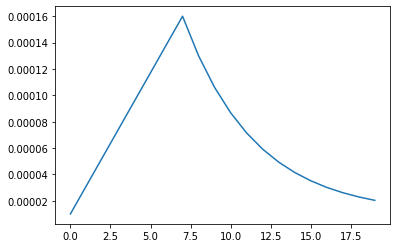

In [6]:
# batch and learning rate settings
if strategy.num_replicas_in_sync == 8: # TPU or 8xGPU
    BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 16 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8
elif strategy.num_replicas_in_sync == 1: # single GPU
    BATCH_SIZE = 16
    VALIDATION_BATCH_SIZE = 16
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.0002
    rampup_epochs = 5
    sustain_epochs = 0
    exp_decay = .8
else: # TPU pod
    BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    VALIDATION_BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    start_lr = 0.00001
    min_lr = 0.00001
    max_lr = 0.00002 * strategy.num_replicas_in_sync
    rampup_epochs = 7
    sustain_epochs = 0
    exp_decay = .8

def lrfn(epoch):
    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        if epoch < rampup_epochs:
            lr = (max_lr - start_lr)/rampup_epochs * epoch + start_lr
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        else:
            lr = (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        return lr
    return lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay)
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, [lrfn(x) for x in rng])
print(y[0], y[-1])
print(y)

In [7]:
### earlystop call backs

es_callback = tf.keras.callbacks.EarlyStopping(min_delta=0, patience=5, verbose=1, mode='auto', restore_best_weights=True)

## 4- Visualization utilities

In [8]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

## 5- Dataset loading utility

In [9]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

### this could be modified
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    ### adding enhance data_augment
#     dataset =dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 12753 training images, 3712 validation images, 7382 unlabeled test images


## 6- Oversampling

In [10]:
# create a tuple to calculate # of images for each class
label_count =Counter()

for img,label in load_dataset(TRAINING_FILENAMES):
    label_count.update([label.numpy()])

In [11]:
# sort class by count of images desc
label_count.most_common()

[(67, 782),
 (103, 743),
 (4, 703),
 (49, 563),
 (73, 460),
 (53, 460),
 (48, 422),
 (102, 390),
 (75, 306),
 (0, 272),
 (13, 263),
 (47, 261),
 (68, 260),
 (14, 227),
 (50, 201),
 (45, 172),
 (72, 167),
 (80, 153),
 (87, 146),
 (77, 139),
 (93, 139),
 (71, 137),
 (10, 136),
 (82, 134),
 (94, 131),
 (95, 127),
 (74, 125),
 (46, 125),
 (86, 120),
 (28, 119),
 (76, 119),
 (79, 118),
 (52, 115),
 (83, 112),
 (91, 111),
 (43, 110),
 (29, 109),
 (90, 106),
 (51, 105),
 (30, 105),
 (7, 105),
 (70, 104),
 (81, 101),
 (96, 100),
 (41, 96),
 (88, 96),
 (21, 96),
 (69, 94),
 (62, 93),
 (12, 92),
 (18, 90),
 (56, 89),
 (8, 87),
 (5, 87),
 (78, 86),
 (24, 85),
 (9, 84),
 (25, 83),
 (39, 73),
 (40, 64),
 (57, 63),
 (42, 63),
 (59, 58),
 (55, 58),
 (36, 57),
 (64, 55),
 (16, 55),
 (17, 50),
 (22, 48),
 (89, 46),
 (11, 43),
 (97, 41),
 (54, 37),
 (58, 36),
 (35, 36),
 (98, 34),
 (27, 34),
 (65, 33),
 (84, 31),
 (100, 31),
 (61, 29),
 (85, 29),
 (63, 28),
 (60, 27),
 (1, 26),
 (37, 26),
 (19, 26),
 (1

In [12]:
label_count[96]

100

In [13]:
# set a function to retun repeat count for each class


def num_of_over_sampleing (classes, min_img = 900):
    count = label_count[classes]
    if count >= min_img :
        return 1.0
    
    repeat_num = round(min_img/count,2)
    
    return repeat_num   

In [14]:
# create a dictionary to show repeat number by class

repeat_num_class ={clas : num_of_over_sampleing(clas) for clas in range(len(CLASSES))}

In [15]:
repeat_num_class

{0: 3.31,
 1: 34.62,
 2: 45.0,
 3: 42.86,
 4: 1.28,
 5: 10.34,
 6: 50.0,
 7: 8.57,
 8: 10.34,
 9: 10.71,
 10: 6.62,
 11: 20.93,
 12: 9.78,
 13: 3.42,
 14: 3.96,
 15: 42.86,
 16: 16.36,
 17: 18.0,
 18: 10.0,
 19: 34.62,
 20: 47.37,
 21: 9.38,
 22: 18.75,
 23: 47.37,
 24: 10.59,
 25: 10.84,
 26: 42.86,
 27: 26.47,
 28: 7.56,
 29: 8.26,
 30: 8.57,
 31: 37.5,
 32: 39.13,
 33: 45.0,
 34: 50.0,
 35: 25.0,
 36: 15.79,
 37: 34.62,
 38: 47.37,
 39: 12.33,
 40: 14.06,
 41: 9.38,
 42: 14.29,
 43: 8.18,
 44: 50.0,
 45: 5.23,
 46: 7.2,
 47: 3.45,
 48: 2.13,
 49: 1.6,
 50: 4.48,
 51: 8.57,
 52: 7.83,
 53: 1.96,
 54: 24.32,
 55: 15.52,
 56: 10.11,
 57: 14.29,
 58: 25.0,
 59: 15.52,
 60: 33.33,
 61: 31.03,
 62: 9.68,
 63: 32.14,
 64: 16.36,
 65: 27.27,
 66: 42.86,
 67: 1.15,
 68: 3.46,
 69: 9.57,
 70: 8.65,
 71: 6.57,
 72: 5.39,
 73: 1.96,
 74: 7.2,
 75: 2.94,
 76: 7.56,
 77: 6.47,
 78: 10.47,
 79: 7.63,
 80: 5.88,
 81: 8.91,
 82: 6.72,
 83: 8.04,
 84: 29.03,
 85: 31.03,
 86: 7.5,
 87: 6.16,
 88: 9.38

Define the number of repetitions for each training example

In [16]:
# This will be called later in `get_training_dataset_with_oversample()`

keys_tensor = tf.constant([k for k in repeat_num_class])
vals_tensor = tf.constant([repeat_num_class[k] for k in repeat_num_class])
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), -1)

def get_num_of_repetition_for_example(training_example):
    
    _, label = training_example
    
    num_to_repeat = table.lookup(label)
    num_to_repeat_integral = tf.cast(int(num_to_repeat), tf.float32)
    residue = num_to_repeat - num_to_repeat_integral
    
    num_to_repeat = num_to_repeat_integral + tf.cast(tf.random.uniform(shape=()) <= residue, tf.float32)
    
    return tf.cast(num_to_repeat, tf.int64)

## 7- Use Augmentation to increase samples

In [17]:
### Augmentation for oversample
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))


def transform(image, label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]), label

Tensor flow data augment function

In [18]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 3)
    imgae = tf.image.random_brightness(image,0.4)
    imgae = tf.image.rot90(image)
    imgae = tf.image.central_crop(image,0.4)
    
    return image, label  

Function for getting oversamples

In [19]:
# Function for getting oversample train dataset
# In this notebook, I am going to use Tensor flow dta_augment function
def get_training_dataset_with_oversample(repeat_dataset=True, oversample=False, augumentation=False):

    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)

    if oversample:
        dataset = dataset.flat_map(lambda image, label: tf.data.Dataset.from_tensors((image, label)).repeat(get_num_of_repetition_for_example((image, label))))

    if augumentation:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    
    if repeat_dataset:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
    
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    return dataset

Check oversampled dataset

In [20]:
oversampled_training_dataset = get_training_dataset_with_oversample(repeat_dataset=False, oversample=True, augumentation=False)

label_counter_2 = Counter()
for images, labels in oversampled_training_dataset:
    label_counter_2.update(labels.numpy())

del oversampled_training_dataset

label_counting_sorted_2 = label_counter_2.most_common()

NUM_TRAINING_IMAGES_OVERSAMPLED = sum([x[1] for x in label_counting_sorted_2])
print("number of examples in the oversampled training dataset: {}".format(NUM_TRAINING_IMAGES_OVERSAMPLED))

print("labels in the oversampled training dataset, sorted by occurrence")
label_counting_sorted_2

number of examples in the oversampled training dataset: 93658
labels in the oversampled training dataset, sorted by occurrence


[(77, 913),
 (103, 910),
 (29, 910),
 (93, 909),
 (7, 909),
 (47, 908),
 (67, 908),
 (53, 908),
 (78, 907),
 (24, 906),
 (72, 906),
 (49, 906),
 (37, 905),
 (22, 905),
 (36, 905),
 (21, 905),
 (75, 905),
 (52, 905),
 (41, 905),
 (62, 904),
 (46, 904),
 (12, 904),
 (55, 903),
 (50, 903),
 (45, 903),
 (28, 903),
 (95, 903),
 (87, 902),
 (19, 902),
 (69, 902),
 (13, 902),
 (61, 902),
 (83, 902),
 (1, 902),
 (88, 902),
 (3, 902),
 (60, 902),
 (91, 901),
 (98, 901),
 (100, 901),
 (39, 901),
 (0, 901),
 (31, 901),
 (66, 901),
 (38, 901),
 (89, 901),
 (56, 901),
 (11, 901),
 (63, 900),
 (65, 900),
 (58, 900),
 (48, 900),
 (86, 900),
 (32, 900),
 (84, 900),
 (73, 900),
 (17, 900),
 (101, 900),
 (33, 900),
 (92, 900),
 (71, 900),
 (2, 900),
 (96, 900),
 (44, 900),
 (79, 900),
 (35, 900),
 (97, 900),
 (6, 900),
 (34, 900),
 (51, 900),
 (18, 900),
 (27, 900),
 (85, 899),
 (94, 899),
 (81, 899),
 (15, 899),
 (8, 899),
 (10, 899),
 (16, 899),
 (30, 898),
 (23, 898),
 (43, 898),
 (25, 898),
 (99, 89

Dataset visualizations

In [21]:
# data dump
print("Training data shapes:")
for image, label in get_training_dataset_with_oversample(repeat_dataset=True, oversample=True, augumentation=True).take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in get_validation_dataset().take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())

print("Test data shapes:")
for image, idnum in get_test_dataset().take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Training data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Training data label examples: [83 44 67 ... 42 84 94]
Validation data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Validation data label examples: [ 53  47  68 ...   4 102  56]
Test data shapes:
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
(128, 512, 512, 3) (128,)
Test data IDs: ['ee2b50aed' 'bff69770d' '22324cd72' ... '8e96d5481' 'c1553af6a' '2ce2f09d3']


In [22]:
# Peek at training data
training_dataset =  get_training_dataset_with_oversample(repeat_dataset=True, oversample=True, augumentation=True)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

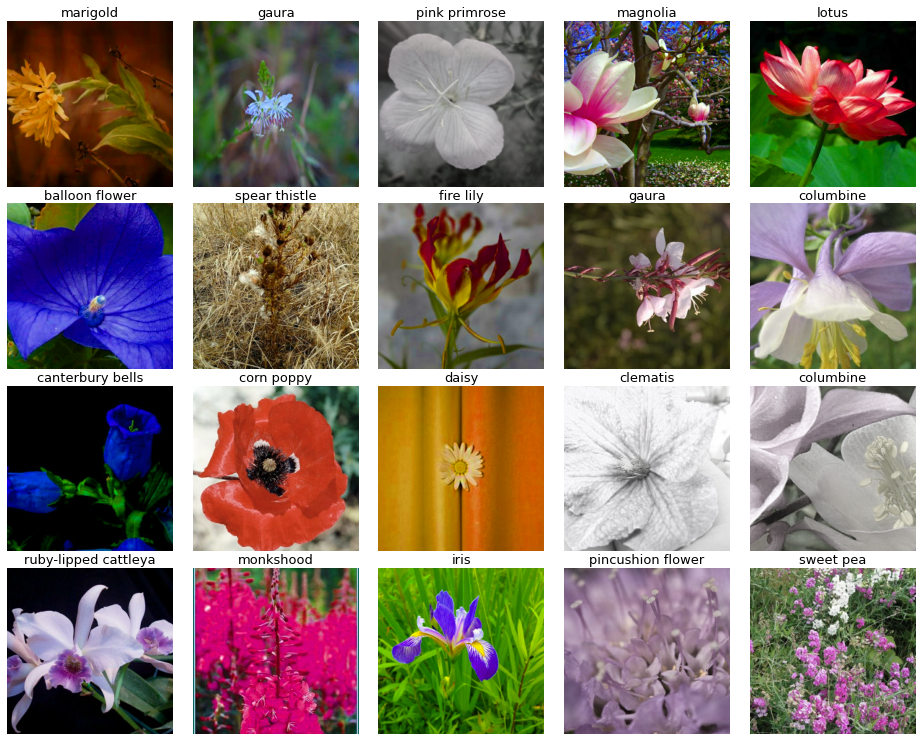

In [23]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [24]:
# peek at test data
test_dataset = get_test_dataset()
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

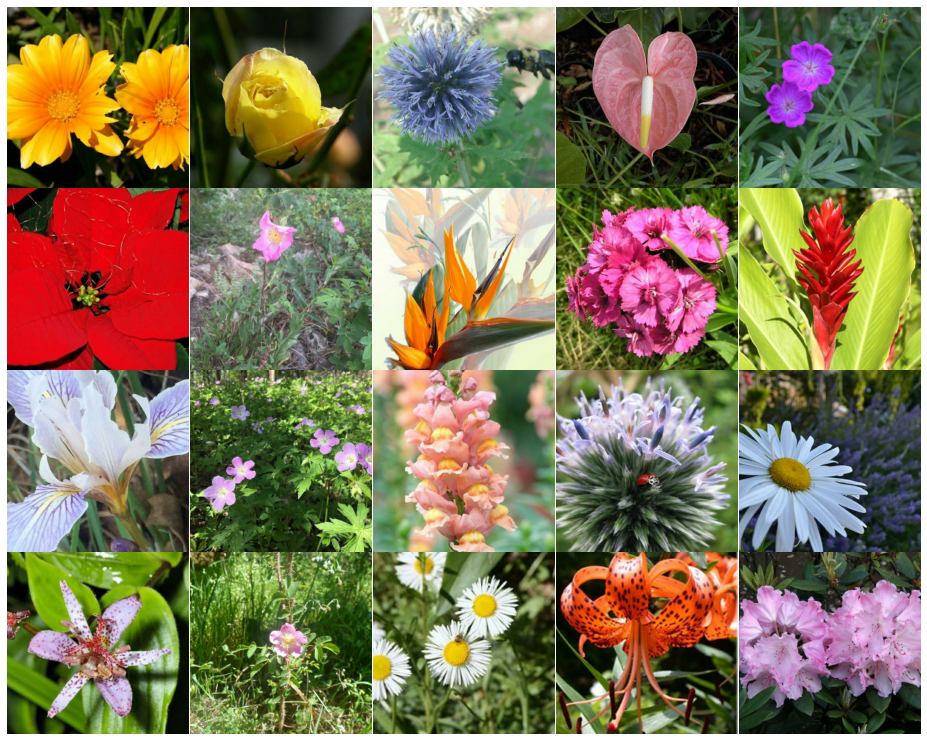

In [25]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

Model

In [26]:
### Model 3
with strategy.scope():
    EfficientNetB7 = efn.EfficientNetB7(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
    EfficientNetB7.trainable =True
    
    model3=tf.keras.Sequential([
           EfficientNetB7,
           tf.keras.layers.GlobalAveragePooling2D(),
           tf.keras.layers.Dense(len(CLASSES),activation ='softmax')                    
       ])
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate =0.0001,beta_1 = 0.9, beta_2 =0.999, amsgrad =False),
    metrics=['sparse_categorical_accuracy']  
)
model3.summary()

258441216/258434480 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 104)               266344    
Total params: 64,364,024
Trainable params: 64,053,304
Non-trainable params: 310,720
_________________________________________________________________


In [27]:
### Train model3
start = datetime.datetime.now()
history3 = model3.fit(get_training_dataset_with_oversample(repeat_dataset=True, oversample=True, augumentation=True), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=get_validation_dataset(),callbacks =[lr_callback,es_callback])
#callbacks =[lr_callback]
# callbacks =[lr_callback,es_callback]
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 421s 4s/step - loss: 4.6045 - sparse_categorical_accuracy: 0.0265 - val_loss: 4.5475 - val_sparse_categorical_accuracy: 0.0345

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-05.
Epoch 2/20
99/99 [==============================] - 106s 1s/step - loss: 4.2375 - sparse_categorical_accuracy: 0.2506 - val_loss: 3.9056 - val_sparse_categorical_accuracy: 0.3341

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714286e-05.
Epoch 3/20
99/99 [==============================] - 105s 1s/step - loss: 2.7953 - sparse_categorical_accuracy: 0.5783 - val_loss: 2.0657 - val_sparse_categorical_accuracy: 0.5991

Epoch 00004: LearningRateScheduler reducing learning rate to 7.428571428571429e-05.
Epoch 4/20
99/99 [==============================] - 105s 1s/step - loss: 1.2654 - sparse_categorical_accuracy: 0.8100 - 

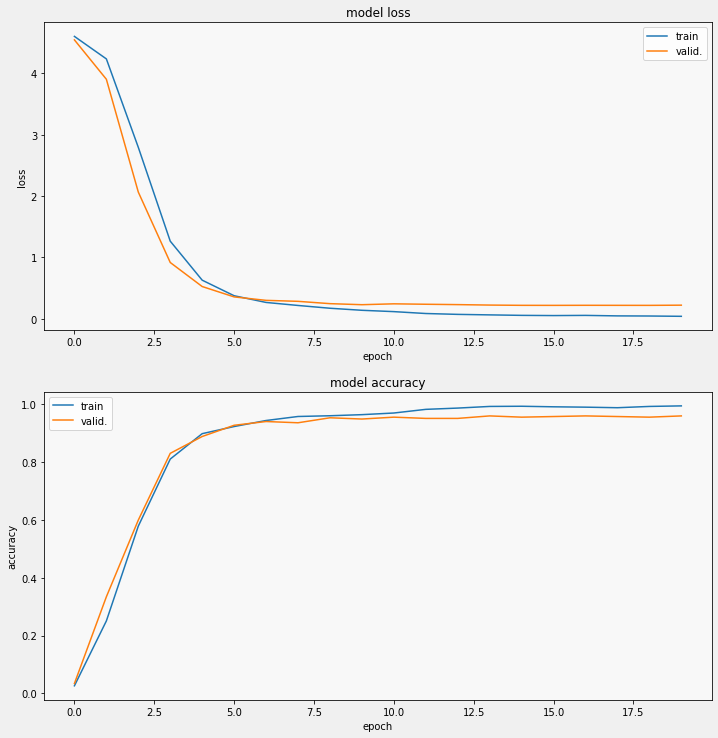

In [28]:
display_training_curves(history3.history['loss'], history3.history['val_loss'], 'loss', 211)
display_training_curves(history3.history['sparse_categorical_accuracy'], history3.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

Save the model and traing again with additional augmentation

In [29]:
model3.save('model3_train.h5')

Confusion Matrix

In [30]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities =model3.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


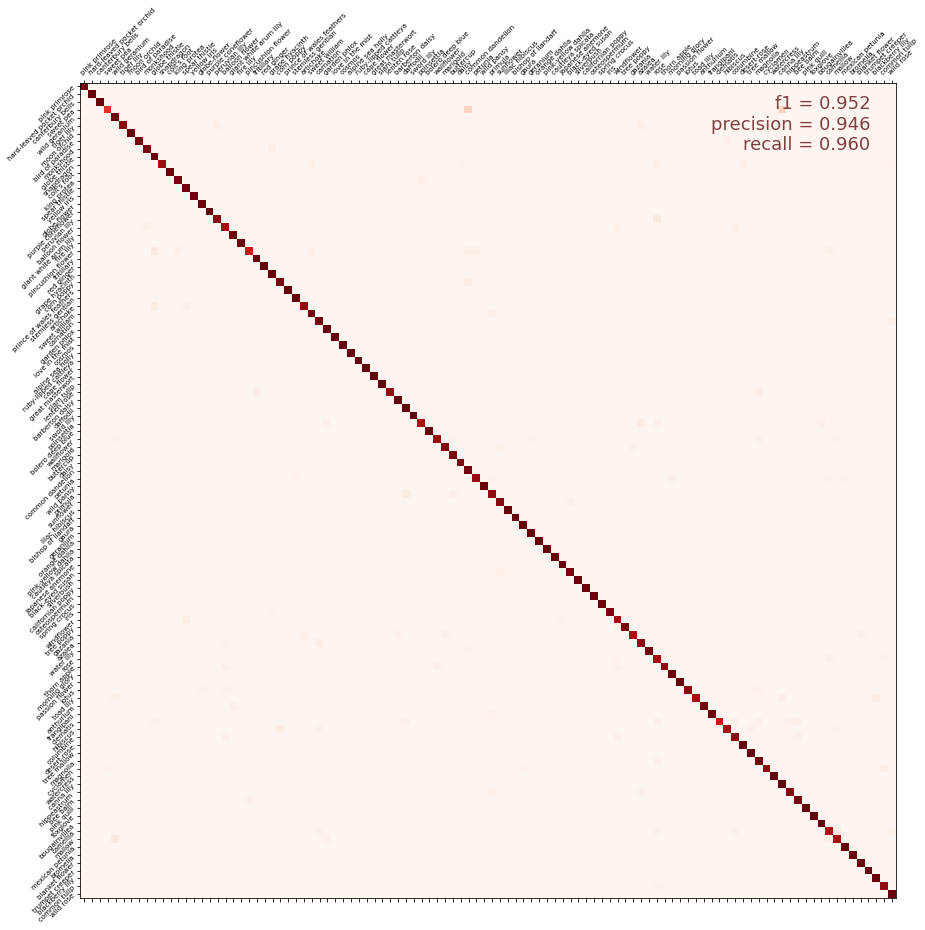

f1 score: 0.952, precision: 0.946, recall: 0.960


In [31]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

Check score for each class

In [32]:
report =metrics.classification_report(cm_correct_labels,cm_predictions, output_dict =True)
report_df =pd.DataFrame(report).transpose()

In [33]:
Poor_Perform =report_df[report_df["f1-score"] < 0.94].sort_values(["f1-score"])
print("Total {} calss are under 0.94".format(len(Poor_Perform)))

Total 38 calss are under 0.94


In [34]:
## list all idx which have poor performance
idx = [int(label) for label in Poor_Perform.index]
idx

[3,
 95,
 18,
 21,
 15,
 96,
 81,
 68,
 31,
 71,
 70,
 9,
 61,
 52,
 43,
 73,
 30,
 83,
 34,
 62,
 35,
 86,
 82,
 102,
 97,
 28,
 17,
 89,
 46,
 101,
 10,
 99,
 78,
 50,
 45,
 77,
 5,
 25]

In [35]:
def num_of_over_sampleing_new (classes, min_img = 900):
    count = label_count[classes]
    if classes in idx :
        repeat_num = round((min_img+600)/count,2)
    if count >= min_img :
        repeat_num = 1
    if classes not in idx :
        repeat_num = 1
    
    
    
    return repeat_num   

In [36]:
repeat_num_class_new ={clas : num_of_over_sampleing_new(clas) for clas in range(len(CLASSES))}

In [37]:
repeat_num_class_new

{0: 1,
 1: 1,
 2: 1,
 3: 71.43,
 4: 1,
 5: 17.24,
 6: 1,
 7: 1,
 8: 1,
 9: 17.86,
 10: 11.03,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 71.43,
 16: 1,
 17: 30.0,
 18: 16.67,
 19: 1,
 20: 1,
 21: 15.62,
 22: 1,
 23: 1,
 24: 1,
 25: 18.07,
 26: 1,
 27: 1,
 28: 12.61,
 29: 1,
 30: 14.29,
 31: 62.5,
 32: 1,
 33: 1,
 34: 83.33,
 35: 41.67,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 13.64,
 44: 1,
 45: 8.72,
 46: 12.0,
 47: 1,
 48: 1,
 49: 1,
 50: 7.46,
 51: 1,
 52: 13.04,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 51.72,
 62: 16.13,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 5.77,
 69: 1,
 70: 14.42,
 71: 10.95,
 72: 1,
 73: 3.26,
 74: 1,
 75: 1,
 76: 1,
 77: 10.79,
 78: 17.44,
 79: 1,
 80: 1,
 81: 14.85,
 82: 11.19,
 83: 13.39,
 84: 1,
 85: 1,
 86: 12.5,
 87: 1,
 88: 1,
 89: 32.61,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 11.81,
 96: 15.0,
 97: 36.59,
 98: 1,
 99: 62.5,
 100: 1,
 101: 60.0,
 102: 3.85,
 103: 1}

In [38]:
# This will be called later in `get_training_dataset_with_oversample()`

keys_tensor = tf.constant([k for k in repeat_num_class_new])
vals_tensor = tf.constant([repeat_num_class_new[k] for k in repeat_num_class_new])
table_new = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor), -1)

def get_num_of_repetition_for_example_new(training_example):
    
    _, label = training_example
    
    num_to_repeat = table_new.lookup(label)
    num_to_repeat_integral = tf.cast(int(num_to_repeat), tf.float32)
    residue = num_to_repeat - num_to_repeat_integral
    
    num_to_repeat = num_to_repeat_integral + tf.cast(tf.random.uniform(shape=()) <= residue, tf.float32)
    
    return tf.cast(num_to_repeat, tf.int64)

In [39]:
# Function for getting oversample train dataset
# In this notebook, I am going to use Tensor flow dta_augment function
def get_training_dataset_with_oversample_new(repeat_dataset=True, oversample=False, augumentation=False):

    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)

    if oversample:
        dataset = dataset.flat_map(lambda image, label: tf.data.Dataset.from_tensors((image, label)).repeat(get_num_of_repetition_for_example_new((image, label))))

    if augumentation:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    
    if repeat_dataset:
        dataset = dataset.repeat() # the training dataset must repeat for several epochs
    
    dataset = dataset.shuffle(20000)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    
    return dataset

In [40]:
poor_oversampled_training_dataset = get_training_dataset_with_oversample_new(repeat_dataset=False, oversample=True, augumentation=False)

label_counter_3 = Counter()
for images, labels in poor_oversampled_training_dataset:
    label_counter_3.update(labels.numpy())

del poor_oversampled_training_dataset

label_counting_sorted_3 = label_counter_3.most_common()

POOR_NUM_TRAINING_IMAGES_OVERSAMPLED = sum([x[1] for x in label_counting_sorted_3])
print("number of examples in the oversampled training dataset: {}".format(NUM_TRAINING_IMAGES_OVERSAMPLED))

print("labels in the oversampled training dataset, sorted by occurrence")
label_counting_sorted_3

number of examples in the oversampled training dataset: 93658
labels in the oversampled training dataset, sorted by occurrence


[(68, 1510),
 (30, 1507),
 (43, 1507),
 (28, 1506),
 (45, 1506),
 (97, 1505),
 (50, 1505),
 (86, 1505),
 (102, 1505),
 (31, 1505),
 (62, 1505),
 (89, 1504),
 (70, 1503),
 (35, 1503),
 (71, 1503),
 (5, 1502),
 (21, 1502),
 (61, 1502),
 (3, 1501),
 (96, 1500),
 (73, 1500),
 (17, 1500),
 (99, 1500),
 (77, 1500),
 (82, 1500),
 (78, 1500),
 (46, 1500),
 (25, 1500),
 (101, 1500),
 (15, 1499),
 (52, 1499),
 (9, 1498),
 (34, 1498),
 (10, 1498),
 (18, 1497),
 (95, 1497),
 (83, 1495),
 (81, 1495),
 (67, 782),
 (103, 743),
 (4, 703),
 (49, 563),
 (53, 460),
 (48, 422),
 (75, 306),
 (0, 272),
 (13, 263),
 (47, 261),
 (14, 227),
 (72, 167),
 (80, 153),
 (87, 146),
 (93, 139),
 (94, 131),
 (74, 125),
 (76, 119),
 (79, 118),
 (91, 111),
 (29, 109),
 (90, 106),
 (7, 105),
 (51, 105),
 (41, 96),
 (88, 96),
 (69, 94),
 (12, 92),
 (56, 89),
 (8, 87),
 (24, 85),
 (39, 73),
 (40, 64),
 (42, 63),
 (57, 63),
 (59, 58),
 (55, 58),
 (36, 57),
 (16, 55),
 (64, 55),
 (22, 48),
 (11, 43),
 (54, 37),
 (58, 36),
 (

In [41]:
report_new =metrics.classification_report(cm_correct_labels,cm_predictions, output_dict =True)
report_df_new =pd.DataFrame(report).transpose()

Train again

In [42]:
### Train model3
start = datetime.datetime.now()
history3_new = model3.fit(get_training_dataset_with_oversample_new(repeat_dataset=True, oversample=True, augumentation=True), steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, validation_data=get_validation_dataset(),callbacks =[lr_callback])
#callbacks =[lr_callback]
# callbacks =[lr_callback,es_callback]
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Train for 99 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/20
99/99 [==============================] - 179s 2s/step - loss: 0.0752 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.2168 - val_sparse_categorical_accuracy: 0.9569

Epoch 00002: LearningRateScheduler reducing learning rate to 3.142857142857143e-05.
Epoch 2/20
99/99 [==============================] - 100s 1s/step - loss: 0.0544 - sparse_categorical_accuracy: 0.9848 - val_loss: 0.2211 - val_sparse_categorical_accuracy: 0.9569

Epoch 00003: LearningRateScheduler reducing learning rate to 5.285714285714286e-05.
Epoch 3/20
99/99 [==============================] - 101s 1s/step - loss: 0.0479 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.2208 - val_sparse_categorical_accuracy: 0.9569

Epoch 00004: LearningRateScheduler reducing learning rate to 7.428571428571429e-05.
Epoch 4/20
99/99 [==============================] - 101s 1s/step - loss: 0.0493 - sparse_categorical_accuracy: 0.9848 - 

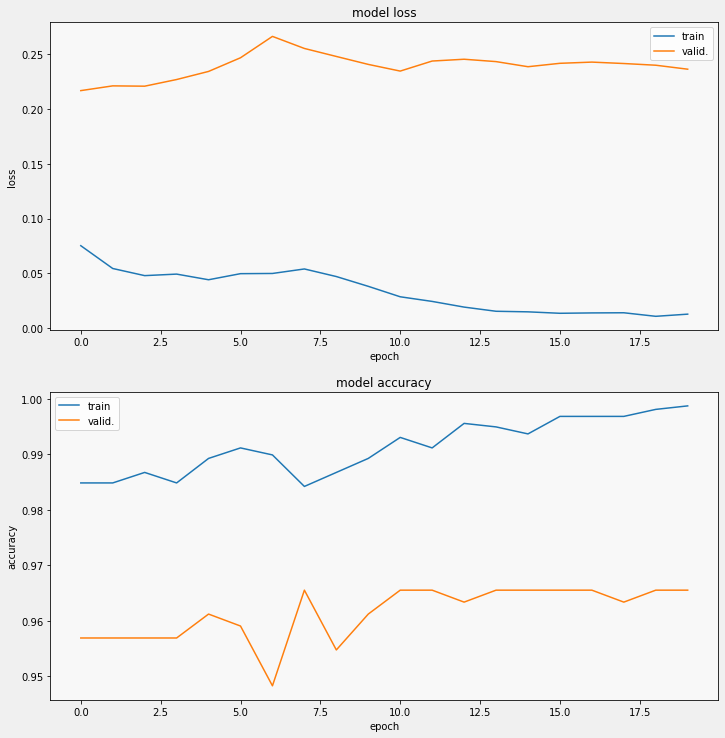

In [43]:
display_training_curves(history3_new.history['loss'], history3_new.history['val_loss'], 'loss', 211)
display_training_curves(history3_new.history['sparse_categorical_accuracy'], history3_new.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

New confusion Matrix

In [44]:
cmdataset = get_validation_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and labels, order matters.
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
cm_correct_labels = next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy() # get everything as one batch
cm_probabilities_new =model3.predict(images_ds)
cm_predictions_new = np.argmax(cm_probabilities_new, axis=-1)
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (3712,) [ 50  13  74 ... 102  48  67]
Predicted labels:  (3712,) [ 50  13  74 ... 102  48  67]


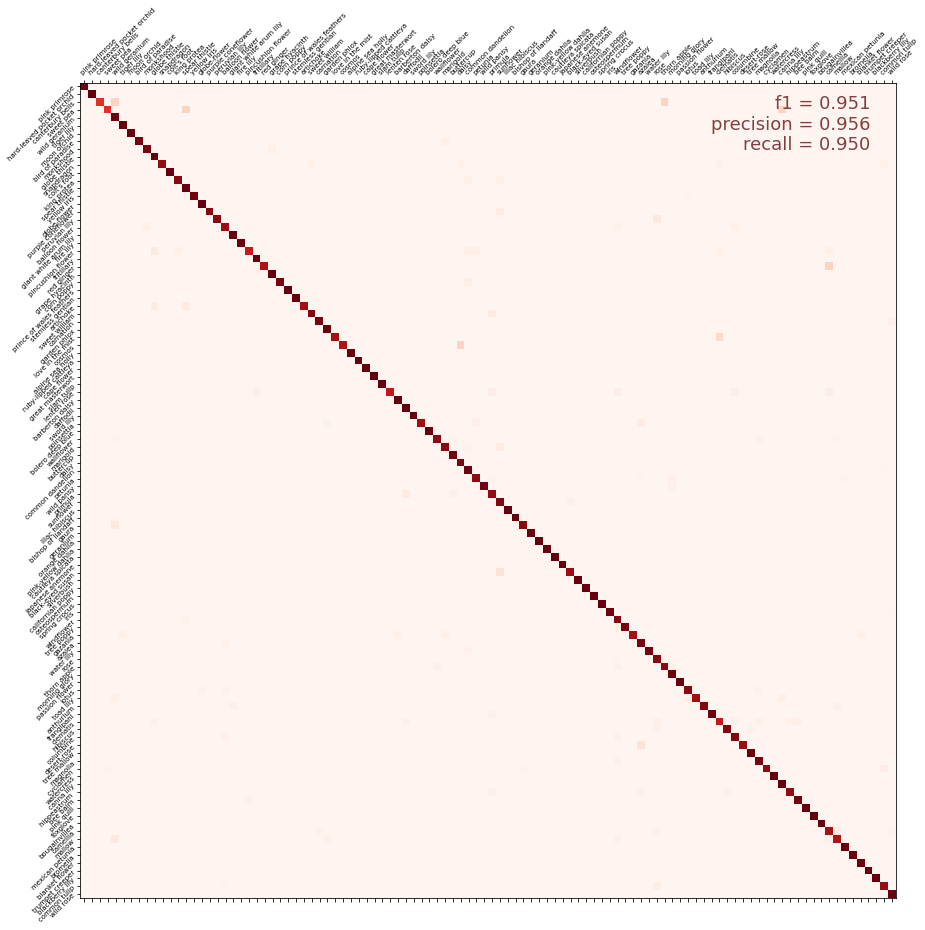

f1 score: 0.951, precision: 0.956, recall: 0.950


In [45]:
cmat = confusion_matrix(cm_correct_labels, cm_predictions_new, labels=range(len(CLASSES)))
score = f1_score(cm_correct_labels, cm_predictions_new, labels=range(len(CLASSES)), average='macro')
precision = precision_score(cm_correct_labels, cm_predictions_new, labels=range(len(CLASSES)), average='macro')
recall = recall_score(cm_correct_labels, cm_predictions_new, labels=range(len(CLASSES)), average='macro')
cmat = (cmat.T / cmat.sum(axis=1)).T # normalized
display_confusion_matrix(cmat, score, precision, recall)
print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

Predictions

In [46]:
test_ds = get_test_dataset(ordered=True) # since we are splitting the dataset and iterating separately on images and ids, order matters.

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model3.predict(test_images_ds)
predictions = np.argmax(probabilities, axis=-1)
print(predictions)

print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U') # all in one batch
np.savetxt('submission.csv', np.rec.fromarrays([test_ids, predictions]), fmt=['%s', '%d'], delimiter=',', header='id,label', comments='')
!head submission.csv

Computing predictions...
[ 67  28  83 ...  86 102  62]
Generating submission.csv file...
id,label
252d840db,67
1c4736dea,28
c37a6f3e9,83
00e4f514e,103
59d1b6146,46
8d808a07b,53
aeb67eefb,52
53cfc6586,29
aaa580243,82


Visual Validation

In [47]:
dataset = get_validation_dataset()
dataset = dataset.unbatch().batch(20)
batch = iter(dataset)

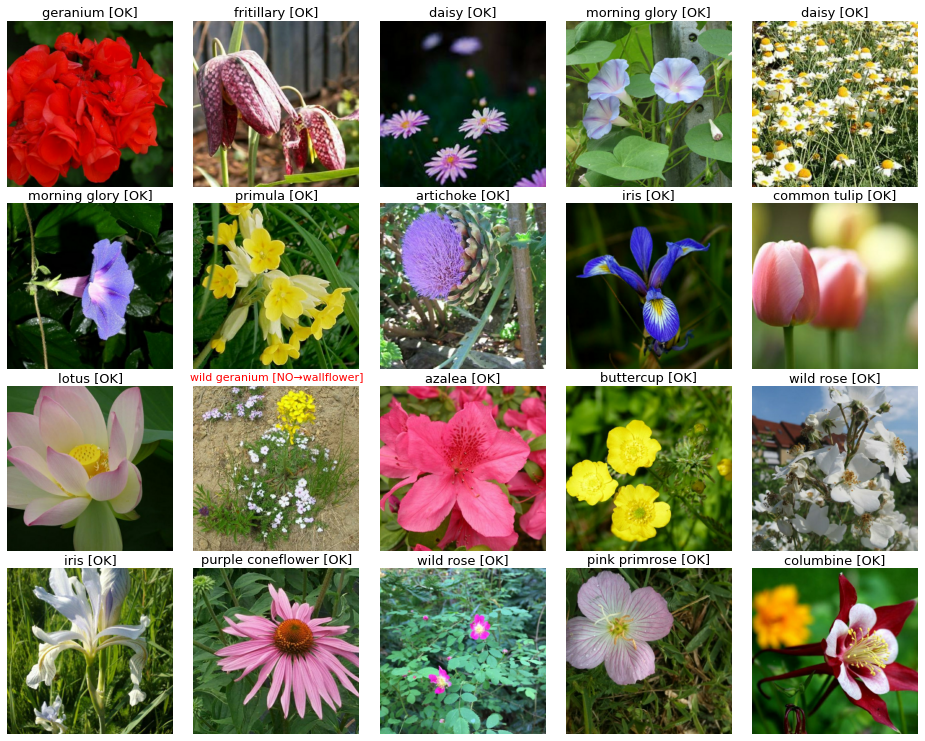

In [48]:
# run this cell again for next set of images
images, labels = next(batch)
probabilities = model3.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)